mean

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [4]:
# TODO: change this to yours ...
#DATA_DIR = "/Users/kwongtszkong/Desktop/STAT3612 Statistical ML/Group Project/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join('/content', 'train.csv')
val_csv_file = os.path.join('/content', 'valid.csv')
test_csv_file = os.path.join('/content', 'test.csv')
ehr_pkl_file = os.path.join('/content', 'ehr_preprocessed_seq_by_day_cat_embedding.pkl')

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [ ]:
#Option1 : Aggregate features by mean over the days



# Extract EHR features and IDs
ehr_features = ehr_data["feat_dict"]
ehr_ids = list(ehr_features.keys())

# Convert to DataFrame (each row is an admission)
ehr_df = pd.DataFrame({
    "id": ehr_ids,
    "ehr_matrix": [ehr_features[id] for id in ehr_ids]
})

# Merge with labels from train/val/test DataFrames
def merge_labels(df, ehr_df):
    return df[["id", "readmitted_within_30days"]].merge(ehr_df, on="id", how="inner")

train_ehr = merge_labels(train_df, ehr_df)
val_ehr = merge_labels(val_df, ehr_df)


def aggregate_ehr(df):
    # Aggregate features (example: mean over days)
    df["ehr_mean"] = df["ehr_matrix"].apply(lambda x: np.mean(x, axis=0))

    # Convert to numpy arrays
    X = np.stack(df["ehr_mean"].values)
    y = df["readmitted_within_30days"].astype(int).values

    return X, y

X_train, y_train = aggregate_ehr(train_ehr)
X_val, y_val = aggregate_ehr(val_ehr)


In [ ]:
#Option 2 Aggregate features by last day
"""
X_train = []
for idx, row in train_df.iterrows():
    X_train.append(ehr_data["feat_dict"][row["id"]][-1])
X_train = np.array(X_train)
print(X_train.shape)
print('train_data:',X_train,'\n')

X_val = []
for idx, row in val_df.iterrows():
    X_val.append(ehr_data["feat_dict"][row["id"]][-1])
X_val = np.array(X_val)
print(X_val.shape)
print('validation_data:,',X_val,'\n')




y_train = train_df['readmitted_within_30days'].values
y_val = val_df['readmitted_within_30days'].values

"""

'\nX_train = []\nfor idx, row in train_df.iterrows():\n    X_train.append(ehr_data["feat_dict"][row["id"]][-1])\nX_train = np.array(X_train)\nprint(X_train.shape)\nprint(\'train_data:\',X_train,\'\n\')\n\nX_val = []\nfor idx, row in val_df.iterrows():\n    X_val.append(ehr_data["feat_dict"][row["id"]][-1])\nX_val = np.array(X_val)\nprint(X_val.shape)\nprint(\'validation_data:,\',X_val,\'\n\')\n\n\n\n\ny_train = train_df[\'readmitted_within_30days\'].values\ny_val = val_df[\'readmitted_within_30days\'].values\n\n'

In [ ]:
from scipy.stats import pointbiserialr
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []


# Calculate correlation for each feature
for i in range(X_train.shape[1]):
    if np.std(X_train[:, i]) == 0:  # Skip constant features
        correlations.append(0)
        p_values.append(1)
    else:
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)



# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',

    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',

    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.9     # Demographics rarely zero
    },
    'std_dev': 0.01,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.01,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]

        # Skip binary features for variance check
        check_variance = ftype not in ['icd']

        # Apply type-specific rules
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (np.abs(row['Correlation']) < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > thresholds['correlation']['max_pvalue']):
            features_to_remove.append(feature)




filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features)
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features)
                     if i not in remove_indices]





<ipython-input-17-15a087a865df>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [ ]:
# print preprocessing result

print(f"\nRecommended features to remove (last) ({len(removal_df)} total):")
print(removal_df[['Feature', 'Zero_Ratio', 'Std_Dev', 'Correlation', 'P-value']])
print("Recommended removal features list:")
print(removal_df['Feature'].tolist())


Recommended features to remove (last) (39 total):
                   Feature  Zero_Ratio   Std_Dev  Correlation   P-value
54                 K65-K68    0.999950  0.015576    -0.008536  0.057676
24                 R40-R46    0.999950  0.102142    -0.003603  0.423045
8                  M80-M85    0.999909  0.007789    -0.004268  0.342633
29                 B25-B34    0.999877  0.029816     0.004573  0.309156
26                 N20-N23    0.999863  0.008993    -0.004928  0.273169
73                 N60-N65    0.999831  0.025824     0.006283  0.162356
47                 G89-G99    0.999813  0.182042     0.007699  0.086893
44                 M50-M54    0.999786  0.000000     0.000000  1.000000
111  Basophils Joint Fluid    0.999758  0.000000     0.000000  1.000000
57                 B65-B83    0.999735  0.006359    -0.003484  0.438443
80                 K40-K46    0.999667  0.000000     0.000000  1.000000
93                 R90-R94    0.999653  0.000000     0.000000  1.000000
39           

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib

def objective(trial):
    k = trial.suggest_int('n_neighbors', 3, 21, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=k,
        weights=weights,
        metric=metric,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, y_proba)

    return auc_score

study = optuna.create_study(direction='maximize')

print("\nStarting Optuna optimization...")
study.optimize(objective, n_trials=50)
print("Optuna optimization finished.")

best_params = study.best_params
best_auc = study.best_value
print(f"\nBest parameters found by Optuna: {best_params}")
print(f"Best Validation AUC achieved during tuning: {best_auc:.4f}")

print("\nTraining final KNN model with best parameters...")
knn_model_best = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_model_best.fit(X_train_scaled, y_train)
print("Final KNN model training complete.")

joblib.dump(knn_model_best, 'knn_model_best.pkl')
print("Best KNN model saved to knn_model_best.pkl")

y_val_pred_best = knn_model_best.predict(X_val_scaled)
y_val_proba_best = knn_model_best.predict_proba(X_val_scaled)[:, 1]
final_auc = roc_auc_score(y_val, y_val_proba_best)
print(f"\nFinal Best KNN Validation AUC: {final_auc:.4f}")
print("Final Best KNN Validation Classification Report:")
print(classification_report(y_val, y_val_pred_best))


[I 2025-04-28 13:58:54,731] A new study created in memory with name: no-name-6873b937-9007-4e4a-a2e9-181484cc0d30



Starting Optuna optimization...


[I 2025-04-28 13:59:08,463] Trial 0 finished with value: 0.5611994707982657 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.5611994707982657.
[I 2025-04-28 14:01:30,822] Trial 1 finished with value: 0.5917414044567714 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.5917414044567714.
[I 2025-04-28 14:03:54,059] Trial 2 finished with value: 0.5932078272443254 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 2 with value: 0.5932078272443254.
[I 2025-04-28 14:04:04,139] Trial 3 finished with value: 0.5566450682223922 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.5932078272443254.
[I 2025-04-28 14:06:25,703] Trial 4 finished with value: 0.6033876582026269 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 w

Optuna optimization finished.

Best parameters found by Optuna: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan'}
Best Validation AUC achieved during tuning: 0.6134

Training final KNN model with best parameters...
Final KNN model training complete.
Best KNN model saved to knn_model_best.pkl

Final Best KNN Validation AUC: 0.6134
Final Best KNN Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86     12800
           1       0.49      0.26      0.34      3921

    accuracy                           0.76     16721
   macro avg       0.65      0.59      0.60     16721
weighted avg       0.73      0.76      0.73     16721



Successfully loaded the best KNN model: knn_model_best.pkl
Predicted probabilities calculated on the validation set.
Calculated AUC score: 0.6134
Plotting the ROC curve...


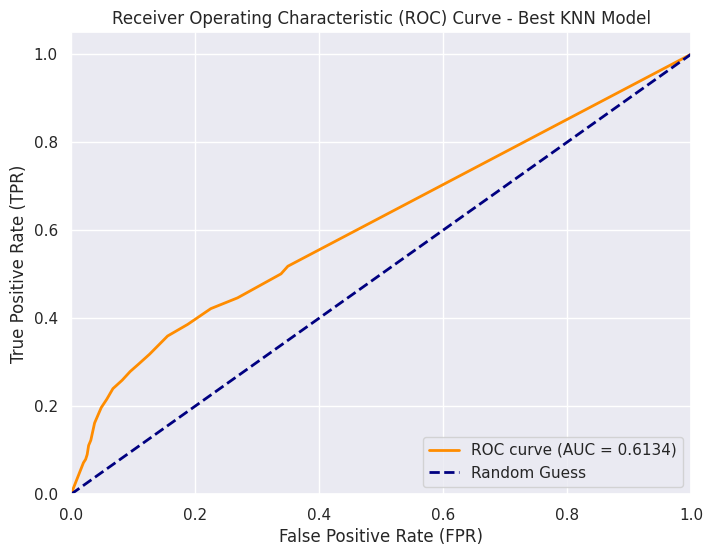

ROC curve plotting complete.


In [ ]:
try:
    knn_model_best = joblib.load('knn_model_best.pkl')
    print("Successfully loaded the best KNN model: knn_model_best.pkl")
except FileNotFoundError:
    print("Error: 'knn_model_best.pkl' file not found. Please ensure the previous code ran successfully and saved the model.")
    # Decide whether to exit or try retraining based on your situation
    exit() # Or raise FileNotFoundError("Model file not found")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    exit()

# --- 2. Predict probabilities on the validation set using the loaded model ---
# Ensure X_val_scaled and y_val are loaded or available in the current environment
try:
    # Check if variables exist, raise an error if not (assuming they should exist)
    if 'X_val_scaled' not in locals() or 'y_val' not in locals():
         raise NameError("Variables 'X_val_scaled' and 'y_val' are required. Please load or generate them first.")

    # Get the predicted probabilities for the positive class
    y_val_proba_best = knn_model_best.predict_proba(X_val_scaled)[:, 1]
    print("Predicted probabilities calculated on the validation set.")

except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during probability prediction: {e}")
    exit()

# --- 3. Calculate ROC curve points (FPR, TPR) and AUC ---
# Use the true labels and predicted probabilities from the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_best)
# Calculate the AUC score (this should match the final_auc you printed earlier)
auc_score = roc_auc_score(y_val, y_val_proba_best)

print(f"Calculated AUC score: {auc_score:.4f}") # Confirm the AUC value

# --- 4. Plot the ROC Curve ---
print("Plotting the ROC curve...")
plt.figure(figsize=(8, 6)) # Set the figure size
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0]) # Set X-axis limits
plt.ylim([0.0, 1.05]) # Set Y-axis limits (slightly > 1 for better visibility)
plt.xlabel('False Positive Rate (FPR)') # X-axis label
plt.ylabel('True Positive Rate (TPR)') # Y-axis label
plt.title('Receiver Operating Characteristic (ROC) Curve - Best KNN Model') # Plot title
plt.legend(loc="lower right") # Display the legend in the lower right corner
plt.grid(True) # Add grid lines
plt.show() # Display the plot

print("ROC curve plotting complete.")

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler

DATA_DIR = "/content/"
test_csv_file = '/content/test.csv'
ehr_pkl_file = '/content/ehr_preprocessed_seq_by_day_cat_embedding.pkl'
scaler_file = 'scaler.pkl'
knn_model_file = 'knn_model_best.pkl'

print("--- Starting Test Data Prediction using KNN Model ---")

try:
    print(f"Loading test data from: {test_csv_file}")
    test_df = pd.read_csv(test_csv_file)
    print(f"Original test set size: {len(test_df)} rows")

    print(f"Loading EHR data from: {ehr_pkl_file}")
    with open(ehr_pkl_file, 'rb') as f:
        ehr_data = pd.read_pickle(f)

    print(f"Loading fitted scaler from: {scaler_file}")
    scaler = joblib.load(scaler_file)

    print(f"Loading trained KNN model from: {knn_model_file}")
    knn_model_best = joblib.load(knn_model_file)

    if 'remove_indices' not in locals():
         raise NameError("'remove_indices' not found. Please ensure it's calculated or loaded from the training phase.")
    print(f"Using 'remove_indices' with {len(remove_indices)} indices.")

    if 'remove_features' not in locals():
        def remove_features(X, remove_indices):
             print(f"Removing features at indices: {len(remove_indices)}")
             return np.delete(X, remove_indices, axis=1)
        print("Defined 'remove_features' function.")
    else:
        print("Using existing 'remove_features' function.")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please check file paths.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()


test_ids = test_df['id'].unique()
test_df_processed = test_df.drop_duplicates(subset='id', keep='first').set_index('id').loc[test_ids].reset_index()
print(f"Test set size with unique IDs: {len(test_df_processed)} rows")

print("Extracting features for test set...")
X_test = []
missing_ids_in_ehr = []
processed_ids = []

for idx, row in test_df_processed.iterrows():
    patient_id = row["id"]
    if patient_id in ehr_data.get("feat_dict", {}):
        X_test.append(ehr_data["feat_dict"][patient_id][-1])
        processed_ids.append(patient_id)
    else:
        missing_ids_in_ehr.append(patient_id)
        print(f"Warning: ID {patient_id} not found in ehr_data['feat_dict']. This ID will be skipped.")

X_test = np.array(X_test)
print(f"Extracted features shape for test set: {X_test.shape}")

if missing_ids_in_ehr:
    print(f"Total missing IDs in ehr_data: {len(missing_ids_in_ehr)}. Predictions will only be generated for {len(processed_ids)} IDs.")
    test_df_processed = test_df_processed[test_df_processed['id'].isin(processed_ids)].reset_index(drop=True)
    print(f"Adjusted test_df_processed size to match features: {len(test_df_processed)} rows")

if X_test.shape[0] != len(test_df_processed):
    print(f"CRITICAL ERROR: Mismatch between extracted features ({X_test.shape[0]}) and processed IDs ({len(test_df_processed)}).")
    exit()

print("Applying feature removal...")
X_test_filtered = remove_features(X_test, remove_indices)
print(f"Test features shape after removing columns: {X_test_filtered.shape}")

print("Scaling test data...")
X_test_scaled = scaler.transform(X_test_filtered)
print(f"Test data scaled successfully. Shape: {X_test_scaled.shape}")

print("Predicting probabilities using the loaded KNN model...")
try:
    test_probabilities = knn_model_best.predict_proba(X_test_scaled)[:, 1]
    print("Predicted probabilities generated successfully.")
except Exception as e:
    print(f"Error predicting probabilities with KNN model: {e}")
    exit()

print("Creating submission DataFrame...")
submission_df = pd.DataFrame({
    'id': test_df_processed['id'],
    'readmitted_within_30days': test_probabilities
})

if len(submission_df) != X_test_scaled.shape[0]:
    print(f"CRITICAL ERROR: Submission rows ({len(submission_df)}) mismatch feature rows ({X_test_scaled.shape[0]})!")
    exit()

print(f"Submission DataFrame shape: {submission_df.shape}")

submission_filename = 'submission_knn.csv'
try:
    submission_df.to_csv(submission_filename, index=False)
    print(f"Submission file created successfully: {submission_filename}")
except Exception as e:
    print(f"Error saving submission file: {e}")

print("--- Test Data Prediction Complete ---")


--- Starting Test Data Prediction using KNN Model ---
Loading test data from: /content/test.csv
Original test set size: 16293 rows
Loading EHR data from: /content/ehr_preprocessed_seq_by_day_cat_embedding.pkl
Loading fitted scaler from: scaler.pkl
Error loading file: [Errno 2] No such file or directory: 'scaler.pkl'. Please check file paths.
Test set size with unique IDs: 2741 rows
Extracting features for test set...
Extracted features shape for test set: (2741, 171)
Applying feature removal...


NameError: name 'remove_features' is not defined

last day

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
joblib.dump(scaler, 'scaler.pkl')

In [5]:
# TODO: change this to yours ...
#DATA_DIR = "/Users/kwongtszkong/Desktop/STAT3612 Statistical ML/Group Project/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join('/content', 'train.csv')
val_csv_file = os.path.join('/content', 'valid.csv')
test_csv_file = os.path.join('/content', 'test.csv')
ehr_pkl_file = os.path.join('/content', 'ehr_preprocessed_seq_by_day_cat_embedding.pkl')

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [6]:
#Option 2 Aggregate features by last day

X_train = []
for idx, row in train_df.iterrows():
    X_train.append(ehr_data["feat_dict"][row["id"]][-1])
X_train = np.array(X_train)
print(X_train.shape)
print('train_data:',X_train,'\n')

X_val = []
for idx, row in val_df.iterrows():
    X_val.append(ehr_data["feat_dict"][row["id"]][-1])
X_val = np.array(X_val)
print(X_val.shape)
print('validation_data:,',X_val,'\n')




y_train = train_df['readmitted_within_30days'].values
y_val = val_df['readmitted_within_30days'].values



(49451, 171)
train_data: [[52  1  6 ...  0  0  0]
 [52  1  6 ...  0  0  0]
 [52  1  6 ...  0  0  0]
 ...
 [91  1  6 ...  0  0  1]
 [69  0  6 ...  0  0  0]
 [69  0  6 ...  0  0  0]] 

(16721, 171)
validation_data:, [[75  0  6 ...  3  6  0]
 [75  0  6 ...  3  6  0]
 [75  0  6 ...  3  6  0]
 ...
 [77  1  6 ...  0  0  0]
 [49  1  6 ...  0  0  0]
 [49  1  6 ...  0  0  0]] 



In [7]:
from scipy.stats import pointbiserialr
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []


# Calculate correlation for each feature
for i in range(X_train.shape[1]):
    if np.std(X_train[:, i]) == 0:  # Skip constant features
        correlations.append(0)
        p_values.append(1)
    else:
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)



# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',

    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',

    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.9     # Demographics rarely zero
    },
    'std_dev': 0.01,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.01,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]

        # Skip binary features for variance check
        check_variance = ftype not in ['icd']

        # Apply type-specific rules
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (np.abs(row['Correlation']) < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > thresholds['correlation']['max_pvalue']):
            features_to_remove.append(feature)




filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features)
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features)
                     if i not in remove_indices]





<ipython-input-7-15a087a865df>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [8]:
print(f"\nRecommended features to remove (last) ({len(removal_df)} total):")
print(removal_df[['Feature', 'Zero_Ratio', 'Std_Dev', 'Correlation', 'P-value']])
print("Recommended removal features list:")
print(removal_df['Feature'].tolist())


Recommended features to remove (last) (44 total):
                        Feature  Zero_Ratio   Std_Dev  Correlation   P-value
54                      K65-K68    0.999950  0.015576    -0.008536  0.057676
24                      R40-R46    0.999950  0.102142    -0.003603  0.423045
8                       M80-M85    0.999909  0.007789    -0.004268  0.342633
29                      B25-B34    0.999877  0.029816     0.004573  0.309156
26                      N20-N23    0.999863  0.008993    -0.004928  0.273169
73                      N60-N65    0.999831  0.025824     0.006283  0.162356
47                      G89-G99    0.999813  0.182042     0.007699  0.086893
44                      M50-M54    0.999786  0.000000     0.000000  1.000000
111       Basophils Joint Fluid    0.999758  0.000000     0.000000  1.000000
57                      B65-B83    0.999735  0.006359    -0.003484  0.438443
80                      K40-K46    0.999667  0.000000     0.000000  1.000000
93                      R

In [9]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [11]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.9 MB/s eta 0:00:00


In [12]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib

def objective(trial):
    k = trial.suggest_int('n_neighbors', 3, 21, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=k,
        weights=weights,
        metric=metric,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, y_proba)

    return auc_score

study = optuna.create_study(direction='maximize')

print("\nStarting Optuna optimization...")
study.optimize(objective, n_trials=15)
print("Optuna optimization finished.")

best_params = study.best_params
best_auc = study.best_value
print(f"\nBest parameters found by Optuna: {best_params}")
print(f"Best Validation AUC achieved during tuning: {best_auc:.4f}")

print("\nTraining final KNN model with best parameters...")
knn_model_best = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_model_best.fit(X_train_scaled, y_train)
print("Final KNN model training complete.")

joblib.dump(knn_model_best, 'knn_model_best.pkl')
print("Best KNN model saved to knn_model_best.pkl")

y_val_pred_best = knn_model_best.predict(X_val_scaled)
y_val_proba_best = knn_model_best.predict_proba(X_val_scaled)[:, 1]
final_auc = roc_auc_score(y_val, y_val_proba_best)
print(f"\nFinal Best KNN Validation AUC: {final_auc:.4f}")
print("Final Best KNN Validation Classification Report:")
print(classification_report(y_val, y_val_pred_best))


[I 2025-04-29 01:41:38,059] A new study created in memory with name: no-name-37634076-8ff0-4274-acc1-351841310260



Starting Optuna optimization...


[I 2025-04-29 01:42:03,217] Trial 0 finished with value: 0.6229403771359346 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.6229403771359346.
[I 2025-04-29 01:44:23,477] Trial 1 finished with value: 0.6639678573705687 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.6639678573705687.
[I 2025-04-29 01:44:34,168] Trial 2 finished with value: 0.6216682407230298 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.6639678573705687.
[I 2025-04-29 01:46:54,311] Trial 3 finished with value: 0.6539796926804388 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.6639678573705687.
[I 2025-04-29 01:49:14,647] Trial 4 finished with value: 0.6560289546671768 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 

Optuna optimization finished.

Best parameters found by Optuna: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan'}
Best Validation AUC achieved during tuning: 0.6640

Training final KNN model with best parameters...
Final KNN model training complete.
Best KNN model saved to knn_model_best.pkl

Final Best KNN Validation AUC: 0.6640
Final Best KNN Validation Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.92      0.87     12800
        True       0.55      0.33      0.41      3921

    accuracy                           0.78     16721
   macro avg       0.69      0.62      0.64     16721
weighted avg       0.76      0.78      0.76     16721



In [14]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Successfully loaded the best KNN model: knn_model_best.pkl
Predicted probabilities calculated on the validation set.
Calculated AUC score: 0.6640
Plotting the ROC curve...


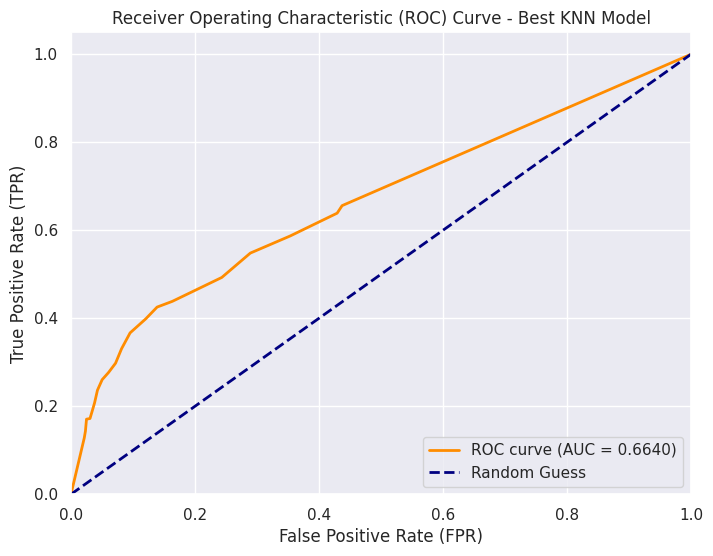

ROC curve plotting complete.


In [15]:
try:
    knn_model_best = joblib.load('knn_model_best.pkl')
    print("Successfully loaded the best KNN model: knn_model_best.pkl")
except FileNotFoundError:
    print("Error: 'knn_model_best.pkl' file not found. Please ensure the previous code ran successfully and saved the model.")
    # Decide whether to exit or try retraining based on your situation
    exit() # Or raise FileNotFoundError("Model file not found")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    exit()

# --- 2. Predict probabilities on the validation set using the loaded model ---
# Ensure X_val_scaled and y_val are loaded or available in the current environment
try:
    # Check if variables exist, raise an error if not (assuming they should exist)
    if 'X_val_scaled' not in locals() or 'y_val' not in locals():
         raise NameError("Variables 'X_val_scaled' and 'y_val' are required. Please load or generate them first.")

    # Get the predicted probabilities for the positive class
    y_val_proba_best = knn_model_best.predict_proba(X_val_scaled)[:, 1]
    print("Predicted probabilities calculated on the validation set.")

except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during probability prediction: {e}")
    exit()

# --- 3. Calculate ROC curve points (FPR, TPR) and AUC ---
# Use the true labels and predicted probabilities from the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_best)
# Calculate the AUC score (this should match the final_auc you printed earlier)
auc_score = roc_auc_score(y_val, y_val_proba_best)

print(f"Calculated AUC score: {auc_score:.4f}") # Confirm the AUC value

# --- 4. Plot the ROC Curve ---
print("Plotting the ROC curve...")
plt.figure(figsize=(8, 6)) # Set the figure size
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0]) # Set X-axis limits
plt.ylim([0.0, 1.05]) # Set Y-axis limits (slightly > 1 for better visibility)
plt.xlabel('False Positive Rate (FPR)') # X-axis label
plt.ylabel('True Positive Rate (TPR)') # Y-axis label
plt.title('Receiver Operating Characteristic (ROC) Curve - Best KNN Model') # Plot title
plt.legend(loc="lower right") # Display the legend in the lower right corner
plt.grid(True) # Add grid lines
plt.show() # Display the plot

print("ROC curve plotting complete.")

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler

DATA_DIR = "/content/"
test_csv_file = '/content/test.csv'
ehr_pkl_file = '/content/ehr_preprocessed_seq_by_day_cat_embedding.pkl'
scaler_file = 'scaler.pkl'
knn_model_file = 'knn_model_best.pkl'

print("--- Starting Test Data Prediction using KNN Model ---")

try:
    print(f"Loading test data from: {test_csv_file}")
    test_df = pd.read_csv(test_csv_file)
    print(f"Original test set size: {len(test_df)} rows")

    print(f"Loading EHR data from: {ehr_pkl_file}")
    with open(ehr_pkl_file, 'rb') as f:
        ehr_data = pd.read_pickle(f)

    print(f"Loading fitted scaler from: {scaler_file}")
    scaler = joblib.load(scaler_file)

    print(f"Loading trained KNN model from: {knn_model_file}")
    knn_model_best = joblib.load(knn_model_file)

    if 'remove_indices' not in locals():
         raise NameError("'remove_indices' not found. Please ensure it's calculated or loaded from the training phase.")
    print(f"Using 'remove_indices' with {len(remove_indices)} indices.")

    if 'remove_features' not in locals():
        def remove_features(X, remove_indices):
             print(f"Removing features at indices: {len(remove_indices)}")
             return np.delete(X, remove_indices, axis=1)
        print("Defined 'remove_features' function.")
    else:
        print("Using existing 'remove_features' function.")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please check file paths.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()


test_ids = test_df['id'].unique()
test_df_processed = test_df.drop_duplicates(subset='id', keep='first').set_index('id').loc[test_ids].reset_index()
print(f"Test set size with unique IDs: {len(test_df_processed)} rows")

print("Extracting features for test set...")
X_test = []
missing_ids_in_ehr = []
processed_ids = []

for idx, row in test_df_processed.iterrows():
    patient_id = row["id"]
    if patient_id in ehr_data.get("feat_dict", {}):
        X_test.append(ehr_data["feat_dict"][patient_id][-1])
        processed_ids.append(patient_id)
    else:
        missing_ids_in_ehr.append(patient_id)
        print(f"Warning: ID {patient_id} not found in ehr_data['feat_dict']. This ID will be skipped.")

X_test = np.array(X_test)
print(f"Extracted features shape for test set: {X_test.shape}")

if missing_ids_in_ehr:
    print(f"Total missing IDs in ehr_data: {len(missing_ids_in_ehr)}. Predictions will only be generated for {len(processed_ids)} IDs.")
    test_df_processed = test_df_processed[test_df_processed['id'].isin(processed_ids)].reset_index(drop=True)
    print(f"Adjusted test_df_processed size to match features: {len(test_df_processed)} rows")

if X_test.shape[0] != len(test_df_processed):
    print(f"CRITICAL ERROR: Mismatch between extracted features ({X_test.shape[0]}) and processed IDs ({len(test_df_processed)}).")
    exit()

print("Applying feature removal...")
X_test_filtered = remove_features(X_test, remove_indices)
print(f"Test features shape after removing columns: {X_test_filtered.shape}")

print("Scaling test data...")
X_test_scaled = scaler.transform(X_test_filtered)
print(f"Test data scaled successfully. Shape: {X_test_scaled.shape}")

print("Predicting probabilities using the loaded KNN model...")
try:
    test_probabilities = knn_model_best.predict_proba(X_test_scaled)[:, 1]
    print("Predicted probabilities generated successfully.")
except Exception as e:
    print(f"Error predicting probabilities with KNN model: {e}")
    exit()

print("Creating submission DataFrame...")
submission_df = pd.DataFrame({
    'id': test_df_processed['id'],
    'readmitted_within_30days': test_probabilities
})

if len(submission_df) != X_test_scaled.shape[0]:
    print(f"CRITICAL ERROR: Submission rows ({len(submission_df)}) mismatch feature rows ({X_test_scaled.shape[0]})!")
    exit()

print(f"Submission DataFrame shape: {submission_df.shape}")

submission_filename = 'submission_knn.csv'
try:
    submission_df.to_csv(submission_filename, index=False)
    print(f"Submission file created successfully: {submission_filename}")
except Exception as e:
    print(f"Error saving submission file: {e}")

print("--- Test Data Prediction Complete ---")


--- Starting Test Data Prediction using KNN Model ---
Loading test data from: /content/test.csv
Original test set size: 16293 rows
Loading EHR data from: /content/ehr_preprocessed_seq_by_day_cat_embedding.pkl
Loading fitted scaler from: scaler.pkl
Loading trained KNN model from: knn_model_best.pkl
Using 'remove_indices' with 44 indices.
Using existing 'remove_features' function.
Test set size with unique IDs: 2741 rows
Extracting features for test set...
Extracted features shape for test set: (2741, 171)
Applying feature removal...
Test features shape after removing columns: (2741, 127)
Scaling test data...
Test data scaled successfully. Shape: (2741, 127)
Predicting probabilities using the loaded KNN model...
Predicted probabilities generated successfully.
Creating submission DataFrame...
Submission DataFrame shape: (2741, 2)
Submission file created successfully: submission_knn.csv
--- Test Data Prediction Complete ---


Max

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [ ]:
# TODO: change this to yours ...
#DATA_DIR = "/Users/kwongtszkong/Desktop/STAT3612 Statistical ML/Group Project/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join('/content', 'train.csv')
val_csv_file = os.path.join('/content', 'valid.csv')
test_csv_file = os.path.join('/content', 'test.csv')
ehr_pkl_file = os.path.join('/content', 'ehr_preprocessed_seq_by_day_cat_embedding.pkl')

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [ ]:

# Extract EHR features and IDs
ehr_features = ehr_data["feat_dict"]
ehr_ids = list(ehr_features.keys())

# Convert to DataFrame (each row is an admission)
ehr_df = pd.DataFrame({
    "id": ehr_ids,
    "ehr_matrix": [ehr_features[id] for id in ehr_ids]
})

# Merge with labels from train/val/test DataFrames
def merge_labels(df, ehr_df):
    return df[["id", "readmitted_within_30days"]].merge(ehr_df, on="id", how="inner")

train_ehr = merge_labels(train_df, ehr_df)
val_ehr = merge_labels(val_df, ehr_df)


def aggregate_ehr(df):
    # Aggregate features (example: mean over days)
    df["ehr_max"] = df["ehr_matrix"].apply(lambda x: np.max(x, axis=0))

    # Convert to numpy arrays
    X = np.stack(df["ehr_max"].values)
    y = df["readmitted_within_30days"].astype(int).values

    return X, y

X_train, y_train = aggregate_ehr(train_ehr)
X_val, y_val = aggregate_ehr(val_ehr)


In [ ]:
from scipy.stats import pointbiserialr
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []


# Calculate correlation for each feature
for i in range(X_train.shape[1]):
    if np.std(X_train[:, i]) == 0:  # Skip constant features
        correlations.append(0)
        p_values.append(1)
    else:
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)



# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',

    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',

    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.9     # Demographics rarely zero
    },
    'std_dev': 0.01,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.01,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]

        # Skip binary features for variance check
        check_variance = ftype not in ['icd']

        # Apply type-specific rules
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (np.abs(row['Correlation']) < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > thresholds['correlation']['max_pvalue']):
            features_to_remove.append(feature)




filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features)
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features)
                     if i not in remove_indices]





<ipython-input-5-15a087a865df>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [ ]:
print(f"\nRecommended features to remove (last) ({len(removal_df)} total):")
print(removal_df[['Feature', 'Zero_Ratio', 'Std_Dev', 'Correlation', 'P-value']])
print("Recommended removal features list:")
print(removal_df['Feature'].tolist())


Recommended features to remove (last) (52 total):
                          Feature  Zero_Ratio   Std_Dev  Correlation   P-value
126             Monocytes Ascites    0.999982  0.000000     0.000000  1.000000
54                        K65-K68    0.999950  0.015576    -0.008536  0.057676
24                        R40-R46    0.999950  0.102142    -0.003603  0.423045
8                         M80-M85    0.999909  0.007789    -0.004268  0.342633
128           Lymphocytes Pleural    0.999891  0.000000     0.000000  1.000000
120               Basophils Blood    0.999877  0.000000     0.000000  1.000000
29                        B25-B34    0.999877  0.029816     0.004573  0.309156
26                        N20-N23    0.999863  0.008993    -0.004928  0.273169
73                        N60-N65    0.999831  0.025824     0.006283  0.162356
47                        G89-G99    0.999813  0.182042     0.007699  0.086893
44                        M50-M54    0.999786  0.000000     0.000000  1.000000
1

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib

def objective(trial):
    k = trial.suggest_int('n_neighbors', 3, 21, step=2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=k,
        weights=weights,
        metric=metric,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, y_proba)

    return auc_score

study = optuna.create_study(direction='maximize')

print("\nStarting Optuna optimization...")
study.optimize(objective, n_trials=10)
print("Optuna optimization finished.")

best_params = study.best_params
best_auc = study.best_value
print(f"\nBest parameters found by Optuna: {best_params}")
print(f"Best Validation AUC achieved during tuning: {best_auc:.4f}")

print("\nTraining final KNN model with best parameters...")
knn_model_best = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_model_best.fit(X_train_scaled, y_train)
print("Final KNN model training complete.")

joblib.dump(knn_model_best, 'knn_model_best.pkl')
print("Best KNN model saved to knn_model_best.pkl")

y_val_pred_best = knn_model_best.predict(X_val_scaled)
y_val_proba_best = knn_model_best.predict_proba(X_val_scaled)[:, 1]
final_auc = roc_auc_score(y_val, y_val_proba_best)
print(f"\nFinal Best KNN Validation AUC: {final_auc:.4f}")
print("Final Best KNN Validation Classification Report:")
print(classification_report(y_val, y_val_pred_best))


[I 2025-04-28 17:18:44,239] A new study created in memory with name: no-name-5fb4d08d-c13c-447c-ba89-3cce0654a0fe



Starting Optuna optimization...


[I 2025-04-28 17:19:02,186] Trial 0 finished with value: 0.5685973464199184 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.5685973464199184.
[I 2025-04-28 17:21:26,601] Trial 1 finished with value: 0.5724360514696507 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.5724360514696507.
[I 2025-04-28 17:21:36,899] Trial 2 finished with value: 0.5574832631981638 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.5724360514696507.
[I 2025-04-28 17:21:47,161] Trial 3 finished with value: 0.5406527950459067 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.5724360514696507.
[I 2025-04-28 17:21:57,464] Trial 4 finished with value: 0.5685973464199184 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with

Optuna optimization finished.

Best parameters found by Optuna: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan'}
Best Validation AUC achieved during tuning: 0.5822

Training final KNN model with best parameters...
Final KNN model training complete.
Best KNN model saved to knn_model_best.pkl

Final Best KNN Validation AUC: 0.5822
Final Best KNN Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     12800
           1       0.36      0.20      0.25      3921

    accuracy                           0.73     16721
   macro avg       0.57      0.54      0.54     16721
weighted avg       0.68      0.73      0.70     16721



In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Successfully loaded the best KNN model: knn_model_best.pkl
Predicted probabilities calculated on the validation set.
Calculated AUC score: 0.5822
Plotting the ROC curve...


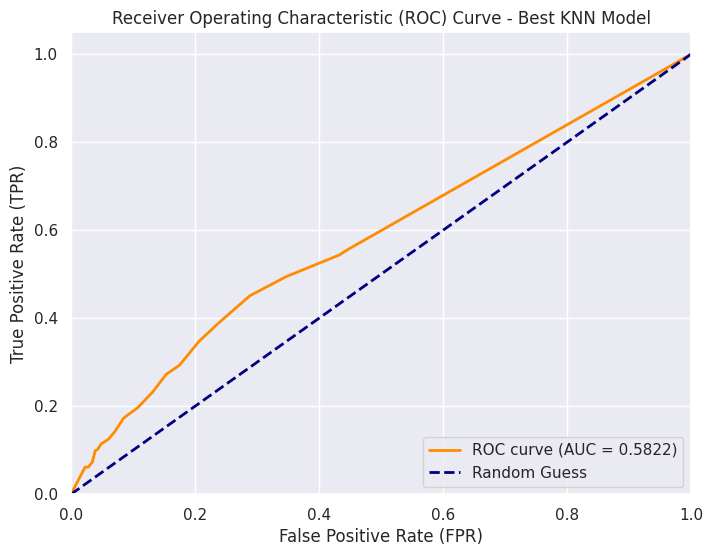

ROC curve plotting complete.


In [ ]:
try:
    knn_model_best = joblib.load('knn_model_best.pkl')
    print("Successfully loaded the best KNN model: knn_model_best.pkl")
except FileNotFoundError:
    print("Error: 'knn_model_best.pkl' file not found. Please ensure the previous code ran successfully and saved the model.")
    # Decide whether to exit or try retraining based on your situation
    exit() # Or raise FileNotFoundError("Model file not found")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    exit()

# --- 2. Predict probabilities on the validation set using the loaded model ---
# Ensure X_val_scaled and y_val are loaded or available in the current environment
try:
    # Check if variables exist, raise an error if not (assuming they should exist)
    if 'X_val_scaled' not in locals() or 'y_val' not in locals():
         raise NameError("Variables 'X_val_scaled' and 'y_val' are required. Please load or generate them first.")

    # Get the predicted probabilities for the positive class
    y_val_proba_best = knn_model_best.predict_proba(X_val_scaled)[:, 1]
    print("Predicted probabilities calculated on the validation set.")

except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during probability prediction: {e}")
    exit()

# --- 3. Calculate ROC curve points (FPR, TPR) and AUC ---
# Use the true labels and predicted probabilities from the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_best)
# Calculate the AUC score (this should match the final_auc you printed earlier)
auc_score = roc_auc_score(y_val, y_val_proba_best)

print(f"Calculated AUC score: {auc_score:.4f}") # Confirm the AUC value

# --- 4. Plot the ROC Curve ---
print("Plotting the ROC curve...")
plt.figure(figsize=(8, 6)) # Set the figure size
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0]) # Set X-axis limits
plt.ylim([0.0, 1.05]) # Set Y-axis limits (slightly > 1 for better visibility)
plt.xlabel('False Positive Rate (FPR)') # X-axis label
plt.ylabel('True Positive Rate (TPR)') # Y-axis label
plt.title('Receiver Operating Characteristic (ROC) Curve - Best KNN Model') # Plot title
plt.legend(loc="lower right") # Display the legend in the lower right corner
plt.grid(True) # Add grid lines
plt.show() # Display the plot

print("ROC curve plotting complete.")

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler

DATA_DIR = "/content/"
test_csv_file = '/content/test.csv'
ehr_pkl_file = '/content/ehr_preprocessed_seq_by_day_cat_embedding.pkl'
scaler_file = 'scaler.pkl'
knn_model_file = 'knn_model_best.pkl'

print("--- Starting Test Data Prediction using KNN Model ---")

try:
    print(f"Loading test data from: {test_csv_file}")
    test_df = pd.read_csv(test_csv_file)
    print(f"Original test set size: {len(test_df)} rows")

    print(f"Loading EHR data from: {ehr_pkl_file}")
    with open(ehr_pkl_file, 'rb') as f:
        ehr_data = pd.read_pickle(f)

    print(f"Loading fitted scaler from: {scaler_file}")
    scaler = joblib.load(scaler_file)

    print(f"Loading trained KNN model from: {knn_model_file}")
    knn_model_best = joblib.load(knn_model_file)

    if 'remove_indices' not in locals():
         raise NameError("'remove_indices' not found. Please ensure it's calculated or loaded from the training phase.")
    print(f"Using 'remove_indices' with {len(remove_indices)} indices.")

    if 'remove_features' not in locals():
        def remove_features(X, remove_indices):
             print(f"Removing features at indices: {len(remove_indices)}")
             return np.delete(X, remove_indices, axis=1)
        print("Defined 'remove_features' function.")
    else:
        print("Using existing 'remove_features' function.")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please check file paths.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()


test_ids = test_df['id'].unique()
test_df_processed = test_df.drop_duplicates(subset='id', keep='first').set_index('id').loc[test_ids].reset_index()
print(f"Test set size with unique IDs: {len(test_df_processed)} rows")

print("Extracting features for test set...")
X_test = []
missing_ids_in_ehr = []
processed_ids = []

for idx, row in test_df_processed.iterrows():
    patient_id = row["id"]
    if patient_id in ehr_data.get("feat_dict", {}):
        X_test.append(ehr_data["feat_dict"][patient_id][-1])
        processed_ids.append(patient_id)
    else:
        missing_ids_in_ehr.append(patient_id)
        print(f"Warning: ID {patient_id} not found in ehr_data['feat_dict']. This ID will be skipped.")

X_test = np.array(X_test)
print(f"Extracted features shape for test set: {X_test.shape}")

if missing_ids_in_ehr:
    print(f"Total missing IDs in ehr_data: {len(missing_ids_in_ehr)}. Predictions will only be generated for {len(processed_ids)} IDs.")
    test_df_processed = test_df_processed[test_df_processed['id'].isin(processed_ids)].reset_index(drop=True)
    print(f"Adjusted test_df_processed size to match features: {len(test_df_processed)} rows")

if X_test.shape[0] != len(test_df_processed):
    print(f"CRITICAL ERROR: Mismatch between extracted features ({X_test.shape[0]}) and processed IDs ({len(test_df_processed)}).")
    exit()

print("Applying feature removal...")
X_test_filtered = remove_features(X_test, remove_indices)
print(f"Test features shape after removing columns: {X_test_filtered.shape}")

print("Scaling test data...")
X_test_scaled = scaler.transform(X_test_filtered)
print(f"Test data scaled successfully. Shape: {X_test_scaled.shape}")

print("Predicting probabilities using the loaded KNN model...")
try:
    test_probabilities = knn_model_best.predict_proba(X_test_scaled)[:, 1]
    print("Predicted probabilities generated successfully.")
except Exception as e:
    print(f"Error predicting probabilities with KNN model: {e}")
    exit()

print("Creating submission DataFrame...")
submission_df = pd.DataFrame({
    'id': test_df_processed['id'],
    'readmitted_within_30days': test_probabilities
})

if len(submission_df) != X_test_scaled.shape[0]:
    print(f"CRITICAL ERROR: Submission rows ({len(submission_df)}) mismatch feature rows ({X_test_scaled.shape[0]})!")
    exit()

print(f"Submission DataFrame shape: {submission_df.shape}")

submission_filename = 'submission_knn.csv'
try:
    submission_df.to_csv(submission_filename, index=False)
    print(f"Submission file created successfully: {submission_filename}")
except Exception as e:
    print(f"Error saving submission file: {e}")

print("--- Test Data Prediction Complete ---")


--- Starting Test Data Prediction using KNN Model ---
Loading test data from: /content/test.csv
Original test set size: 16293 rows
Loading EHR data from: /content/ehr_preprocessed_seq_by_day_cat_embedding.pkl
Loading fitted scaler from: scaler.pkl
Loading trained KNN model from: knn_model_best.pkl
Using 'remove_indices' with 52 indices.
Using existing 'remove_features' function.
Test set size with unique IDs: 2741 rows
Extracting features for test set...
Extracted features shape for test set: (2741, 171)
Applying feature removal...
Test features shape after removing columns: (2741, 119)
Scaling test data...
Test data scaled successfully. Shape: (2741, 119)
Predicting probabilities using the loaded KNN model...
Predicted probabilities generated successfully.
Creating submission DataFrame...
Submission DataFrame shape: (2741, 2)
Submission file created successfully: submission_knn.csv
--- Test Data Prediction Complete ---
